In [1]:
import h5py
import numpy as np
import puma
import matplotlib.pyplot as plt
from puma import Histogram, HistogramPlot, Roc, RocPlot
from puma.metrics import calc_rej
from puma.utils import get_good_colours, get_good_linestyles, logger
from sklearn import metrics
from numpy.lib.recfunctions import structured_to_unstructured as s2u
import tqdm.notebook as tqdm

In [2]:
%load_ext autoreload
%autoreload 2

# Settings

In [3]:
plt.rcParams.update({
    "figure.facecolor":  "w", 
    "axes.facecolor":    "w", 
    "savefig.facecolor": "w", 
})

In [4]:
jet_pt_min = 15
apply_true_prongness = True

In [5]:
### Define scan of signal efficiencies
sig_eff_min = 0.2 #0.4
sig_eff = np.linspace(sig_eff_min, 1.0, 100)
# if sig_eff_min < 0.2 and key != 'RNN':
#     sig_eff = np.linspace(0.2, 1, 20)

In [6]:
sig_eff

array([0.2       , 0.20808081, 0.21616162, 0.22424242, 0.23232323,
       0.24040404, 0.24848485, 0.25656566, 0.26464646, 0.27272727,
       0.28080808, 0.28888889, 0.2969697 , 0.30505051, 0.31313131,
       0.32121212, 0.32929293, 0.33737374, 0.34545455, 0.35353535,
       0.36161616, 0.36969697, 0.37777778, 0.38585859, 0.39393939,
       0.4020202 , 0.41010101, 0.41818182, 0.42626263, 0.43434343,
       0.44242424, 0.45050505, 0.45858586, 0.46666667, 0.47474747,
       0.48282828, 0.49090909, 0.4989899 , 0.50707071, 0.51515152,
       0.52323232, 0.53131313, 0.53939394, 0.54747475, 0.55555556,
       0.56363636, 0.57171717, 0.57979798, 0.58787879, 0.5959596 ,
       0.6040404 , 0.61212121, 0.62020202, 0.62828283, 0.63636364,
       0.64444444, 0.65252525, 0.66060606, 0.66868687, 0.67676768,
       0.68484848, 0.69292929, 0.7010101 , 0.70909091, 0.71717172,
       0.72525253, 0.73333333, 0.74141414, 0.74949495, 0.75757576,
       0.76565657, 0.77373737, 0.78181818, 0.78989899, 0.79797

In [7]:
networks = {
    # "GN1Tau" : "logs/GN1_tau_20230215-T172736/ckpts/epoch=021-val_loss=0.31938__test_ttbar.h5"
    # 'GN1Tau': "logs/GN1_tau_20230321-T145044/ckpts/epoch=018-val_loss=0.08698__test_inclusive_testing_ttbar_PFlow.h5"
    # 'GN1Tau' : "logs/GN1_tau_20230325-T210222/ckpts/epoch=023-val_loss=0.07746__test_inclusive_testing_ttbar_PFlow.h5"
    #  'GN2TauA': 'logs/GN2TauA_20230820-T185727/ckpts/epoch=009-val_loss=0.04711__test_pp_output_test.h5' ,
    #  "GN2TauJ" : "logs/GN2TauJ_20230713-T111312/ckpts/epoch=010-val_loss=0.05086__test_pp_output_test.h5" ,
    #  "GN2TauC" : "logs/GN2TauC_20230713-T151458/ckpts/epoch=011-val_loss=0.05114__test_pp_output_test.h5" ,
    #  "GN2Tau" : "logs/GN2Tau_20230726-T175600/ckpts/epoch=008-val_loss=0.05920__test_pp_output_test.h5"
    #"GN2Tau" : "logs/GN2Tau_20230508-T191218/ckpts/epoch=021-val_loss=0.07711__test_PFlow.h5"
    # "GN1Tau" : "/storage/agrp/zivka/salt/run/logs/GN1_tau_20230226-T104411/ckpts/epoch=028-val_loss=0.28814__test_inclusive_testing_ttbar_PFlow.h5",
    # "GN1Tau + Aux" : "logs/GN1_tau_20230218-T231137/ckpts/epoch=028-val_loss=0.28814__test_ttbar.h5"
    #"GN2TauA": "/storage/agrp/dreyet/GNtau/salt/logs/GN2TauA_20230918-T144357/ckpts/epoch=012-val_loss=0.05973__test_pp_output_test.h5"
    #"GNTau_noAux": "/storage/agrp/dreyet/GNtau/salt/logs/GN2Tau_noAux_20230920-T112330/ckpts/epoch=028-val_loss=0.06778__test_pp_output_test.h5",
    #"GNTauA": "/storage/agrp/dreyet/GNtau/salt/logs/GN2TauA_20230918-T144357/ckpts/epoch=017-val_loss=0.05848__test_pp_output_test.h5",
    #"GN2TauA_trkClsWgt_noRNN": "/storage/agrp/dreyet/GNtau/salt/logs/GN2TauA_trkClsWgt_noRNN_20230927-T145302/ckpts/epoch=031-val_loss=0.05314__test_pp_output_test.h5",
    #"GN2TauA_trkClsWgt_noRNN_noAux": "/storage/agrp/dreyet/GNtau/salt/logs/GN2TauA_trkClsWgt_noRNN_noAux_20230927-T200138/ckpts/epoch=037-val_loss=0.06664__test_pp_output_test.h5",
    "GN2TauA_trkClsWgt_noRNN": "/home/fiaccoda/ntuples/GNTau_samples/logs/GN2TauA_trkClsWgt_noRNN_20230927-T145302/ckpts/epoch=031-val_loss=0.05314__test_test.h5",
    "GN2TauA_trkClsWgt_noRNN_noAux": "/home/fiaccoda/ntuples/GNTau_samples/logs/GN2TauA_trkClsWgt_noRNN_noAux_20230927-T200138/ckpts/epoch=037-val_loss=0.06664__test_pp_output_test.h5"
    #"GN2TauA_trkClsWgt": "/storage/agrp/dreyet/GNtau/salt/logs/GN2TauA_trkClsWgt_20230924-T171327/ckpts/epoch=019-val_loss=0.05785__test_pp_output_test.h5",
    #"GN2Tau_noAux": "/storage/agrp/dreyet/GNtau/salt/logs/GN2Tau_noAux_20230922-T110104/ckpts/epoch=042-val_loss=0.06758__test_pp_output_test.h5",
}

# Get discriminants, rejection, etc

In [8]:
### Not used currently (using pTau directly as discrimnant)
'''
def disc_fct(arr: np.ndarray) -> np.ndarray:
    """Tagger discriminant

    Parameters
    ----------
    arr : numpy.ndarray
        array with with shape (, 2)

    Returns
    -------
    np.ndarray
        Array with the discriminant values inside.
    """
    # you can adapt this for your needs
    return np.log((arr[0] + 1e-10) / (arr[1] + 1e-10))
'''

'\ndef disc_fct(arr: np.ndarray) -> np.ndarray:\n    """Tagger discriminant\n\n    Parameters\n    ----------\n    arr : numpy.ndarray\n        array with with shape (, 2)\n\n    Returns\n    -------\n    np.ndarray\n        Array with the discriminant values inside.\n    """\n    # you can adapt this for your needs\n    return np.log((arr[0] + 1e-10) / (arr[1] + 1e-10))\n'

In [9]:
reference = "RNN"
# reference  = 'GN2Tau'

#test_path =  '/storage/agrp/zivka/umami_Tau/UPP/umami-preprocessing/upp/output/pp_output_test.h5'
#test_path =  '/storage/agrp/dreyet/GNtau/samples/v04/output/pp_output_test.h5'
#test_path = '/home/fiaccoda/ntuples/GNTau_samples/samples/v04/output/pp_output_val.h5'
test_path = '/home/fiaccoda/ntuples/GNTau_samples/samples/v04/output/cat_pp_output_test.h5'
#test_path = '/storage/agrp/zivka/umami_Tau/UPP/umami-preprocessing/upp/output_1/pp_output_test.h5'
#'/storage/agrp/dmitrykl/tauTag/upp/output/pp_output_test.h5'

In [10]:
def print_datasets_and_variables(name, obj):
    if isinstance(obj, h5py.Dataset):
        print('Dataset:', name)
        print('Variables:', list(obj.attrs))

def print_keys_and_variables(filename):
    with h5py.File(filename, 'r') as f:
        for key in f.keys():
            print('Key:', key)
            print('Variables:', list(f[key].attrs))
            
#with h5py.File(test_path, 'r') as f:
#    f.visititems(print_datasets_and_variables)

# Replace 'yourfile.h5' with your actual file name
print_keys_and_variables(test_path)

Key: cells
Variables: []
Key: jets
Variables: ['flavour_label']
Key: tracks
Variables: []


In [11]:
with h5py.File(test_path, 'r') as test_f:
    print('len file = ', len(test_f['jets']['pt']) )
    N_events = len(test_f['jets']['pt'])
    N_Select_events = int(N_events / 1)
    print("They will be selected ", N_Select_events, " events;")

len file =  17400000
They will be selected  17400000  events;


In [12]:
with h5py.File(test_path, 'r') as test_f:
    print('1...')
    jet_pt = test_f['jets']['pt'][:N_Select_events] / 1000
    jet_eta = test_f['jets']['absEta'][:N_Select_events]
    jet_flav = test_f['jets']['HadronConeExclTruthLabelID'][:N_Select_events]
    rnn_pTau = test_f['jets']['TAU_RNNJetScoreSigTrans'][:N_Select_events] #using Trans Score!!!
    rnn_pBkg = 1 - test_f['jets']['TAU_RNNJetScoreSigTrans'][:N_Select_events]
    print('2...')
    track_scores = [test_f['tracks']['rnn_fakeScore'][:N_Select_events],\
                    test_f['tracks']['rnn_chargedScore'][:N_Select_events],\
                    test_f['tracks']['rnn_isolationScore'][:N_Select_events],\
                    test_f['tracks']['rnn_conversionScore'][:N_Select_events] ]
    track_valids = test_f['tracks']['valid'][:N_Select_events]
    track_truth = test_f['tracks']['NewTruthType'][:N_Select_events]
    print('3...')
    n_tracks = np.sum(track_valids, axis=-1)
    prongs = np.sum(np.argmax(np.stack(track_scores,axis=-1), axis=-1)==1, axis=-1)
    eta_mask = (jet_eta < 2.5) & ((jet_eta > 1.57) | (jet_eta < 1.37))
    mask = (rnn_pTau >= 0) & (rnn_pBkg >= 0) & (jet_pt > jet_pt_min) & eta_mask #& ((n_tracks == 1) | (n_tracks == 3))# & (jet_pt < 100)
    print('4...')
    is_tau = jet_flav == 5
    is_bkg = jet_flav == 0
    n_jets_bkg = np.sum(is_bkg & mask)
    rnn_discs = rnn_pTau
    print('5...')

    x = test_f['tracks']['tauTruthProng'][:N_Select_events]
    sig_1_prong = np.isin(x, 1)
    sig_mask_1 = np.any(sig_1_prong, axis=1)
    print('7...')
    sig_3_prong = np.isin(x, 3)
    sig_mask_3 = np.any(sig_3_prong, axis=1)
    sig_mask_0 = np.logical_not(sig_mask_1 | sig_mask_3)


1...
2...
3...
4...
5...
7...


In [13]:
# rnn_discs = rnn_pTau
logger.info("Calculate rejection")
rnn_rej = calc_rej(rnn_discs[is_tau & mask], rnn_discs[is_bkg & mask], sig_eff)

if apply_true_prongness:
    rnn_rej_0 = calc_rej(rnn_discs[is_tau & mask & (prongs!=1) & (prongs!=3) & sig_mask_0], rnn_discs[is_bkg & mask & (prongs!=1) & (prongs!=3)], sig_eff)
    rnn_rej_1 = calc_rej(rnn_discs[is_tau & mask & (prongs==1)& sig_mask_1], rnn_discs[is_bkg & mask & (prongs==1)], sig_eff)
    rnn_rej_3 = calc_rej(rnn_discs[is_tau & mask & (prongs==3)& sig_mask_3], rnn_discs[is_bkg & mask & (prongs==3)], sig_eff)
else:
    rnn_rej_0 = calc_rej(rnn_discs[is_tau & mask & (prongs!=1) & (prongs!=3)], rnn_discs[is_bkg & mask & (prongs!=1) & (prongs!=3)], sig_eff)
    rnn_rej_1 = calc_rej(rnn_discs[is_tau & mask & (prongs==1)], rnn_discs[is_bkg & mask & (prongs==1)], sig_eff)
    rnn_rej_3 = calc_rej(rnn_discs[is_tau & mask & (prongs==3)], rnn_discs[is_bkg & mask & (prongs==3)], sig_eff)

INFO:puma: Calculate rejection


In [14]:
results = {}

In [15]:
results["RNN"] = {
        'sig_eff' : sig_eff,
        'disc' : rnn_discs,
        'rej' : rnn_rej,
        'rej_0' : rnn_rej_0,
        'rej_1' : rnn_rej_1,
        'rej_3' : rnn_rej_3,
        'pTau' : rnn_pTau,
        'pBkg' : rnn_pBkg,
        'prongs' : prongs,
    }

In [16]:
networks

{'GN2TauA_trkClsWgt_noRNN': '/home/fiaccoda/ntuples/GNTau_samples/logs/GN2TauA_trkClsWgt_noRNN_20230927-T145302/ckpts/epoch=031-val_loss=0.05314__test_test.h5',
 'GN2TauA_trkClsWgt_noRNN_noAux': '/home/fiaccoda/ntuples/GNTau_samples/logs/GN2TauA_trkClsWgt_noRNN_noAux_20230927-T200138/ckpts/epoch=037-val_loss=0.06664__test_pp_output_test.h5'}

In [20]:
logger.info("Calculate discriminants and rejection")
for key, val in networks.items():
    print(key, val)
    with h5py.File(val, 'r') as f:
        #if key == 'GN2TauJ':
            pt = f['jets']['pt'] / 1000
            # tracks_pred = f['tracks'].fields(['0', '1', '2', '3', '4', '5', '6'])[:]
            flav = f['jets']['HadronConeExclTruthLabelID']
            is_tau = flav == 5
            is_bkg = flav == 0
            print(f['jets'][0].dtype)
            if 'GN' in key:
                print(f['jets'])
                pTau = f['jets']['{}_pb'.format(key)]
                pBkg = f['jets']['{}_pu'.format(key)]
                discs = pTau
                #discs = disc_fct(np.row_stack([pTau, pBkg])) #with log!!
            # if key == 'GN2Tau' or key == 'GNtau':
            #     pTau = f['jets']['GN2Tau_pb']
            #     pBkg = f['jets']['GN2Tau_pu']
            #     discs = pTau
            #     #discs = disc_fct(np.row_stack([pTau, pBkg])) #with log!!
            # if key == 'GNTauA':
            #     pTau = f['jets']['GN2TauA_pb']
            #     pBkg = f['jets']['GN2TauA_pu']
            #     discs = pTau
            #     #discs = disc_fct(np.row_stack([pTau, pBkg])) #with log!!
            #     #print(discs, key)
            # if key == 'GNTau_noAux' or key == 'GNtau_noAux':
            #     pTau = f['jets']['GN2Tau_noAux_pb']
            #     pBkg = f['jets']['GN2Tau_noAux_pu']
            #     discs = pTau
            #     #discs = disc_fct(np.row_stack([pTau, pBkg])) #with log!!
            #     #print(discs, key)
            # if key == 'GN2TauJ':
            #     pTau = f['jets']['GN2TauJ_pb']
            #     pBkg = f['jets']['GN2TauJ_pu']
            #     discs = pTau
            #     #discs = disc_fct(np.row_stack([pTau, pBkg]))
            #     #print(discs, key)
            # if key == 'GN2TauC':
            #     pTau = f['jets']['GN2TauC_pb']
            #     pBkg = f['jets']['GN2TauC_pu']
            #     discs = pTau
                #discs = disc_fct(np.row_stack([pTau, pBkg]))
                #print(discs, key)
            # # discs = pTau
            # mask = (pt > 20) & (pt < 100)
            # mask = (pt > 5)
            #eta_mask = (jet_eta < 2.5) & ((jet_eta > 1.57) | (jet_eta < 1.37))
            #mask = (pt > 20) & eta_mask #& ((n_tracks == 1) | (n_tracks == 3))# & (jet_pt < 100)
            logger.info("Calculate rejection")
            rej = calc_rej(discs[is_tau & mask], discs[is_bkg & mask], sig_eff)

            if apply_true_prongness:
                rej_0 = calc_rej(discs[is_tau & mask & (prongs!=1) & (prongs!=3) & sig_mask_0], discs[is_bkg & mask & (prongs!=1) & (prongs!=3)], sig_eff)
                rej_1 = calc_rej(discs[is_tau & mask & (prongs==1) & sig_mask_1],  discs[is_bkg & mask & (prongs==1)], sig_eff)
                rej_3 = calc_rej(discs[is_tau & mask & (prongs==3) & sig_mask_3],  discs[is_bkg & mask & (prongs==3)], sig_eff)
            else:
                rej_0 = calc_rej(discs[is_tau & mask & (prongs!=1) & (prongs!=3)], discs[is_bkg & mask & (prongs!=1) & (prongs!=3)], sig_eff)
                rej_1 = calc_rej(discs[is_tau & mask & (prongs==1)],               discs[is_bkg & mask & (prongs==1)], sig_eff)
                rej_3 = calc_rej(discs[is_tau & mask & (prongs==3)],               discs[is_bkg & mask & (prongs==3)], sig_eff)
            #print((mask & (jet_pt > 20) & is_bkg & (prongs == 3)).sum())
            results[key] = {
                    'sig_eff' : sig_eff,
                    'disc' : discs,
                    'rej' : rej,
                    'rej_0' : rej_0,
                    'rej_1' : rej_1,
                    'rej_3' : rej_3,
                    'pTau' : pTau,
                    'pBkg' : pBkg,
                }



INFO:puma: Calculate discriminants and rejection


GNtau_noRNN /home/fiaccoda/ntuples/GNTau_samples/logs/GN2TauA_trkClsWgt_noRNN_20230927-T145302/ckpts/epoch=031-val_loss=0.05314__test_test.h5
[('GN2TauA_trkClsWgt_noRNN_pu', '<f4'), ('GN2TauA_trkClsWgt_noRNN_pb', '<f4'), ('pt', '<f4'), ('absEta', '<f4'), ('HadronConeExclTruthLabelID', '<f4')]
<HDF5 dataset "jets": shape (17400000,), type "|V20">


ValueError: Field GNtau_noRNN_pb does not appear in this type.

In [ ]:
### Reorder for the sake of order on ROC curves
network_names = list(networks.keys())

for network in network_names:
    new_key = network.replace('GN2', 'GN')
    new_key = new_key.replace('Tau', 'tau')
    new_key = new_key.replace('auA', 'au')
    new_key = new_key.replace('_trkClsWgt', '')
    networks[new_key] = networks.pop(network)
    results[new_key] = results.pop(network)

# ROC curves

In [19]:
indices = list(range(0, len(sig_eff), 2)) + [len(sig_eff) - 1]
#indices

### Using sklearn plotting functions

In [72]:
import numpy as np
import matplotlib.pyplot as plt

def plot_multiple_roc_curves(signal_efficiencies_list, background_rejections_list, labels, save_path="roc_curves.png", prong=None):
    """
    Plot multiple ROC curves in the same figure with log scale and a subplot showing the ratio.

    Parameters:
    - signal_efficiencies_list: List of NumPy arrays representing signal efficiency values for each curve.
    - background_rejections_list: List of NumPy arrays representing background rejection values for each curve.
    - labels: List of labels for each curve.
    - save_path: Path to save the ROC curves plot. Default is "roc_curves.png".
    """
    # Check if the input lists have the same length
    if len(signal_efficiencies_list) != len(background_rejections_list) or len(signal_efficiencies_list) != len(labels):
        raise ValueError("Input lists must have the same length.")

    # Create a new figure
    fig, (roc_ax, ratio_ax) = plt.subplots(nrows=2, figsize=(8, 12))
    
    # Plot ROC curves
    for i in range(len(signal_efficiencies_list)):
        auc = np.trapz(signal_efficiencies_list[i], background_rejections_list[i])
        roc_ax.plot( signal_efficiencies_list[i], background_rejections_list[i], label=f'{labels[i]} ') #(AUC = {auc:.2f}')

    roc_ax.set_title('ROC Curves')
    roc_ax.set_xlabel('Signal Efficiency ')
    roc_ax.set_ylabel('Background Rejection (log scale)')
    roc_ax.set_yscale('log')
    if prong: roc_ax.legend(title=prong+"rong", loc='lower left')
    else: roc_ax.legend(loc='lower left')
    roc_ax.grid(True)

    WP = [0.45, 0.60, 0.75, 0.85]
    if prong=="1p":
        WP = [0.60, 0.75, 0.85]
    elif prong=="3p":   
        WP = [0.45, 0.60, 0.75]
        
    # Plot ratio of signal efficiency to background rejection
    for i in range(0, len(signal_efficiencies_list)):
        ratio = background_rejections_list[i] / background_rejections_list[0]
        ratio_auc = np.trapz(ratio, background_rejections_list[i])
        ratio_ax.plot(signal_efficiencies_list[i], ratio, label=f'{labels[i]} / {labels[0]} ') #(AUC = {ratio_auc:.2f})')
        # Print the ratio at specific signal values
        for wp in WP:
            #for i in range(len(signal_efficiencies_list)):
            index = np.argmin(np.abs(signal_efficiencies_list[i] - wp))
            print(f'{labels[i]} Rej at Signal={wp}: {background_rejections_list[i][index]:.2f}')
            print(f'{labels[i]} / {labels[0]} Ratio at Signal={wp}: {ratio[index]:.2f}')

    ratio_ax.set_title('Ratio of Background Rejections')
    ratio_ax.set_xlabel('Signal Efficiency')
    ratio_ax.set_ylabel('Signal Efficiency / Background Rejection')
    #ratio_ax.set_xscale('log')
    if prong: ratio_ax.legend(title=prong+"rong", loc='upper right')
    else: ratio_ax.legend( loc='upper right')
    ratio_ax.grid(True)

    # Save the plot
    plt.savefig(save_path)
    print(f"ROC curves plot saved at: {save_path}")

RNN Rej at Signal=0.6: 28.98
RNN / RNN Ratio at Signal=0.6: 1.00
RNN Rej at Signal=0.75: 15.45
RNN / RNN Ratio at Signal=0.75: 1.00
RNN Rej at Signal=0.85: 9.45
RNN / RNN Ratio at Signal=0.85: 1.00
GNtau Rej at Signal=0.6: 629.73
GNtau / RNN Ratio at Signal=0.6: 21.73
GNtau Rej at Signal=0.75: 212.65
GNtau / RNN Ratio at Signal=0.75: 13.77
GNtau Rej at Signal=0.85: 96.03
GNtau / RNN Ratio at Signal=0.85: 10.17
GNtau_noAux Rej at Signal=0.6: 403.61
GNtau_noAux / RNN Ratio at Signal=0.6: 13.93
GNtau_noAux Rej at Signal=0.75: 146.03
GNtau_noAux / RNN Ratio at Signal=0.75: 9.45
GNtau_noAux Rej at Signal=0.85: 67.62
GNtau_noAux / RNN Ratio at Signal=0.85: 7.16
ROC curves plot saved at: roc_curves_wnoAux_1p.png


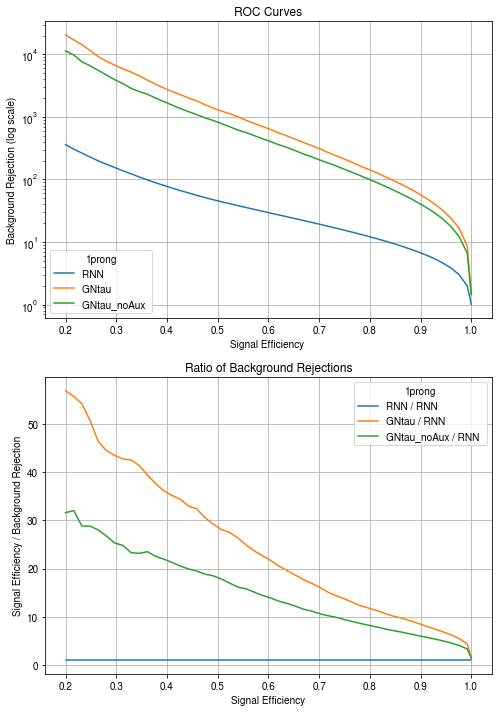

In [73]:
labels = ["RNN", "GNtau", "GNtau_noAux"]
plot_multiple_roc_curves([ sig_eff[indices], sig_eff[indices], sig_eff[indices] ], [ results['RNN'][f'rej_1'][indices], results['GNtau_noRNN'][f'rej_1'][indices], results['GNtau_noRNN_noAux'][f'rej_1'][indices]],\
                             labels, save_path="roc_curves_wnoAux_1p.png", prong="1p")

RNN Rej at Signal=0.45: 430.39
RNN / RNN Ratio at Signal=0.45: 1.00
RNN Rej at Signal=0.6: 151.70
RNN / RNN Ratio at Signal=0.6: 1.00
RNN Rej at Signal=0.75: 59.49
RNN / RNN Ratio at Signal=0.75: 1.00
GNtau Rej at Signal=0.45: 8376.03
GNtau / RNN Ratio at Signal=0.45: 19.46
GNtau Rej at Signal=0.6: 2681.98
GNtau / RNN Ratio at Signal=0.6: 17.68
GNtau Rej at Signal=0.75: 809.58
GNtau / RNN Ratio at Signal=0.75: 13.61
GNtau_noAux Rej at Signal=0.45: 2372.30
GNtau_noAux / RNN Ratio at Signal=0.45: 5.51
GNtau_noAux Rej at Signal=0.6: 766.28
GNtau_noAux / RNN Ratio at Signal=0.6: 5.05
GNtau_noAux Rej at Signal=0.75: 271.20
GNtau_noAux / RNN Ratio at Signal=0.75: 4.56
ROC curves plot saved at: roc_curves_wnoAux_3p.png


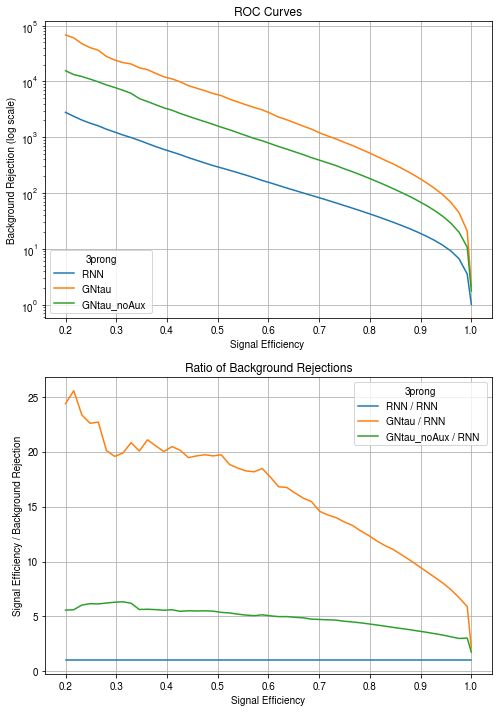

In [74]:
labels = ["RNN", "GNtau", "GNtau_noAux"]
plot_multiple_roc_curves([ sig_eff[indices], sig_eff[indices], sig_eff[indices] ], [ results['RNN'][f'rej_3'][indices], results['GNtau_noRNN'][f'rej_3'][indices], results['GNtau_noRNN_noAux'][f'rej_3'][indices]],\
                         labels, save_path="roc_curves_wnoAux_3p.png", prong="3p")

In [24]:
results['RNN'][f'rej_3'][indices]

array([2.79201026e+03, 2.36713913e+03, 2.02771695e+03, 1.78505574e+03,
       1.59894860e+03, 1.38888265e+03, 1.23596368e+03, 1.09545674e+03,
       9.86307971e+02, 8.75308682e+02, 7.70618542e+02, 6.79702871e+02,
       6.04264151e+02, 5.42813559e+02, 4.87196421e+02, 4.30388933e+02,
       3.85309271e+02, 3.45020279e+02, 3.09958440e+02, 2.81729366e+02,
       2.55666588e+02, 2.31529662e+02, 2.09280031e+02, 1.87803380e+02,
       1.67443334e+02, 1.51697409e+02, 1.36383267e+02, 1.22484139e+02,
       1.10839169e+02, 1.00035278e+02, 9.04238499e+01, 8.18340598e+01,
       7.37376583e+01, 6.63710837e+01, 5.94921051e+01, 5.34710273e+01,
       4.78483104e+01, 4.27465944e+01, 3.80329724e+01, 3.36792552e+01,
       2.97794065e+01, 2.61110738e+01, 2.28224938e+01, 1.97175866e+01,
       1.68518765e+01, 1.41772541e+01, 1.16132762e+01, 9.14928621e+00,
       6.61907396e+00, 3.52005741e+00, 1.00151393e+00])

In [25]:
sig_eff[indices]

array([0.2       , 0.21616162, 0.23232323, 0.24848485, 0.26464646,
       0.28080808, 0.2969697 , 0.31313131, 0.32929293, 0.34545455,
       0.36161616, 0.37777778, 0.39393939, 0.41010101, 0.42626263,
       0.44242424, 0.45858586, 0.47474747, 0.49090909, 0.50707071,
       0.52323232, 0.53939394, 0.55555556, 0.57171717, 0.58787879,
       0.6040404 , 0.62020202, 0.63636364, 0.65252525, 0.66868687,
       0.68484848, 0.7010101 , 0.71717172, 0.73333333, 0.74949495,
       0.76565657, 0.78181818, 0.7979798 , 0.81414141, 0.83030303,
       0.84646465, 0.86262626, 0.87878788, 0.89494949, 0.91111111,
       0.92727273, 0.94343434, 0.95959596, 0.97575758, 0.99191919,
       1.        ])

In [39]:
np.isfinite( results[network]['rej_3'][indices] )

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True])

In [40]:
results[network]['rej_3'][indices][1:]

array([6.04935556e+04, 4.73427826e+04, 4.03290370e+04, 3.62961333e+04,
       2.79201026e+04, 2.41974222e+04, 2.17776800e+04, 2.05449811e+04,
       1.75626452e+04, 1.62520000e+04, 1.39600513e+04, 1.20987111e+04,
       1.11110612e+04, 9.80976577e+03, 8.37603077e+03, 7.56169444e+03,
       6.80552500e+03, 6.08315084e+03, 5.55553061e+03, 4.81807080e+03,
       4.28694488e+03, 3.82064561e+03, 3.41342947e+03, 3.09342045e+03,
       2.68198030e+03, 2.29238737e+03, 2.05062900e+03, 1.79980826e+03,
       1.57809275e+03, 1.39779718e+03, 1.19264403e+03, 1.05003279e+03,
       9.29081911e+02, 8.09579182e+02, 7.10759791e+02, 6.12076447e+02,
       5.28327996e+02, 4.51257356e+02, 3.85172975e+02, 3.30164948e+02,
       2.76999237e+02, 2.31185563e+02, 1.89701045e+02, 1.53342346e+02,
       1.21690210e+02, 9.35386994e+01, 6.81446899e+01, 4.44043716e+01,
       2.07608153e+01, 2.13324295e+00])

# Compute location of working points

In [46]:
def get_disc_cut_for_given_eff(target_eff, disc):
    cut = np.percentile(disc, 100.0 * (1.0 - target_eff))
    return cut

In [47]:
WP_1p = {
    'Tight': 0.60,
    'Medium': 0.75,
    'Loose': 0.85,
}

WP_3p = {
    'Tight': 0.45,
    'Medium': 0.60,
    'Loose': 0.75,
}

prongness = {'1 prongs':[(prongs==1) ,sig_mask_1, WP_1p, 1], '3 prongs' : [(prongs==3), sig_mask_3, WP_3p, 3]}

In [51]:
disc_1p_RNN = results['RNN']['disc'][is_tau & mask & (prongs==1)]
disc_cut_1p_RNN = {key: get_disc_cut_for_given_eff(val, disc_1p_RNN) for key, val in WP_1p.items()}

disc_3p_RNN = results['RNN']['disc'][is_tau & mask & (prongs==3)]
disc_cut_3p_RNN = {key: get_disc_cut_for_given_eff(val, disc_3p_RNN) for key, val in WP_3p.items()}

disc_1p_GNN = results['GNtau_noRNN']['disc'][is_tau & mask & (prongs==1)]
disc_cut_1p_GNN = {key: get_disc_cut_for_given_eff(val, disc_1p_GNN) for key, val in WP_1p.items()}

disc_3p_GNN = results['GNtau_noRNN']['disc'][is_tau & mask & (prongs==3)]
disc_cut_3p_GNN = {key: get_disc_cut_for_given_eff(val, disc_3p_GNN) for key, val in WP_3p.items()}

disc_1p_GNN_nA = results['GNtau_noRNN_noAux']['disc'][is_tau & mask & (prongs==1)]
disc_cut_1p_GNN_nA = {key: get_disc_cut_for_given_eff(val, disc_1p_GNN_nA) for key, val in WP_1p.items()}

disc_3p_GNN_nA = results['GNtau_noRNN_noAux']['disc'][is_tau & mask & (prongs==3)]
disc_cut_3p_GNN_nA = {key: get_disc_cut_for_given_eff(val, disc_3p_GNN_nA) for key, val in WP_3p.items()}

In [52]:
print('1-prong RNN')
print(disc_cut_1p_RNN)
print('3-prong RNN')
print(disc_cut_3p_RNN)
print('1-prong GNN')
print(disc_cut_1p_GNN)
print('3-prong GNN')
print(disc_cut_3p_GNN)
print('1-prong GNN_noAux')
print(disc_cut_1p_GNN_nA)
print('3-prong GNN_noAux')
print(disc_cut_3p_GNN_nA)

1-prong RNN
{'Tight': 0.3765916228294373, 'Medium': 0.22361939400434494, 'Loose': 0.12607046440243722}
3-prong RNN
{'Tight': 0.5425655215978623, 'Medium': 0.38872227072715765, 'Loose': 0.23510169610381126}
1-prong GNN
{'Tight': 0.9985194802284241, 'Medium': 0.9946849346160889, 'Loose': 0.9853282034397125}
3-prong GNN
{'Tight': 0.9994021713733673, 'Medium': 0.9979666948318482, 'Loose': 0.9917172491550446}
1-prong GNN_noAux
{'Tight': 0.9977506995201111, 'Medium': 0.9924755692481995, 'Loose': 0.9796714425086975}
3-prong GNN_noAux
{'Tight': 0.9972502648830414, 'Medium': 0.9916627407073975, 'Loose': 0.972814530134201}


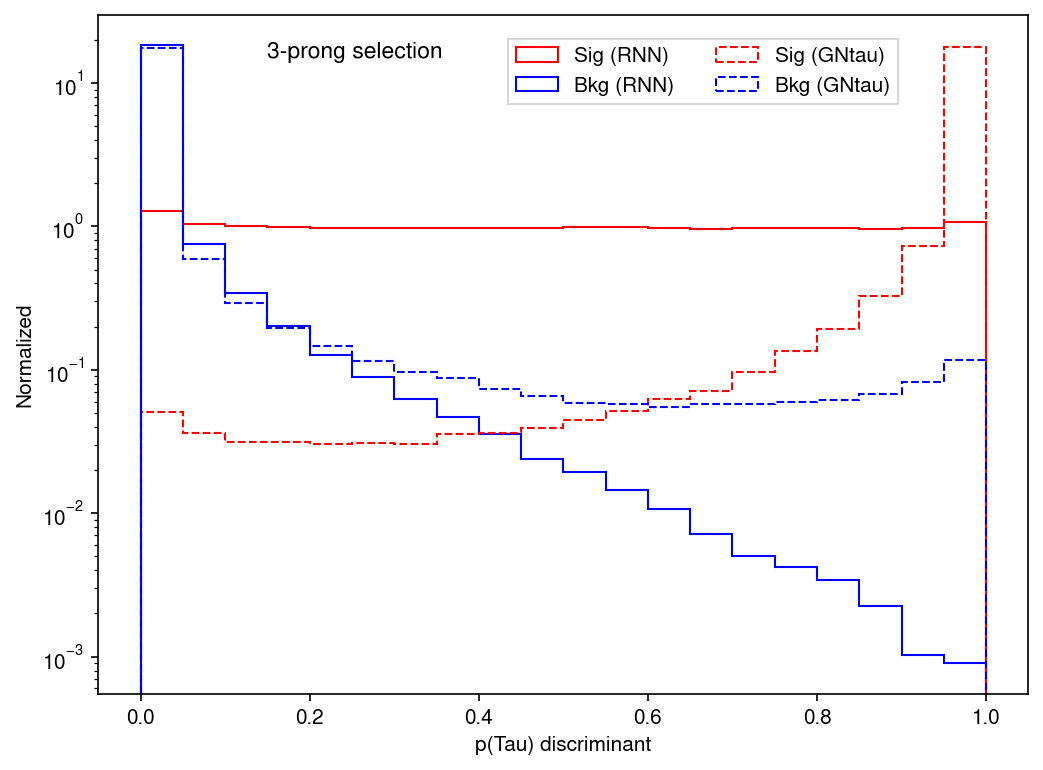

494072


In [23]:
prong_choice = 3

fig, ax = plt.subplots(1, 1, figsize=(8, 6), dpi=150)
ax.hist(results['RNN']['disc'][is_tau & mask & (prongs==prong_choice)], histtype='step', density=True,         range=(0,1), bins=20, color='red', label='Sig (RNN)')
ax.hist(results['RNN']['disc'][is_bkg & mask & (prongs==prong_choice)], histtype='step', density=True,         range=(0,1), bins=20, color='blue', label='Bkg (RNN)')
ax.hist(results['GNtau_noRNN']['disc'][is_tau & mask & (prongs==prong_choice)], histtype='step', density=True, range=(0,1), bins=20, color='red', linestyle=('dashed'), label='Sig (GNtau)')
ax.hist(results['GNtau_noRNN']['disc'][is_bkg & mask & (prongs==prong_choice)], histtype='step', density=True, range=(0,1), bins=20, color='blue', linestyle=('dashed'), label='Bkg (GNtau)')
ax.text(0.15, 15.0, f'{prong_choice}-prong selection', fontsize=11)
ax.set_xlabel('p(Tau) discriminant')
ax.set_ylabel('Normalized')
ax.legend(loc='upper center', bbox_to_anchor=(0.65, 0.98), ncol=2, fancybox=False, shadow=False)
plt.yscale('log')
plt.savefig(f'discriminants_{prong_choice}p.png', transparent=False)
plt.show()
print( len( results['RNN']['disc'][is_tau & mask & (prongs==prong_choice)] ))

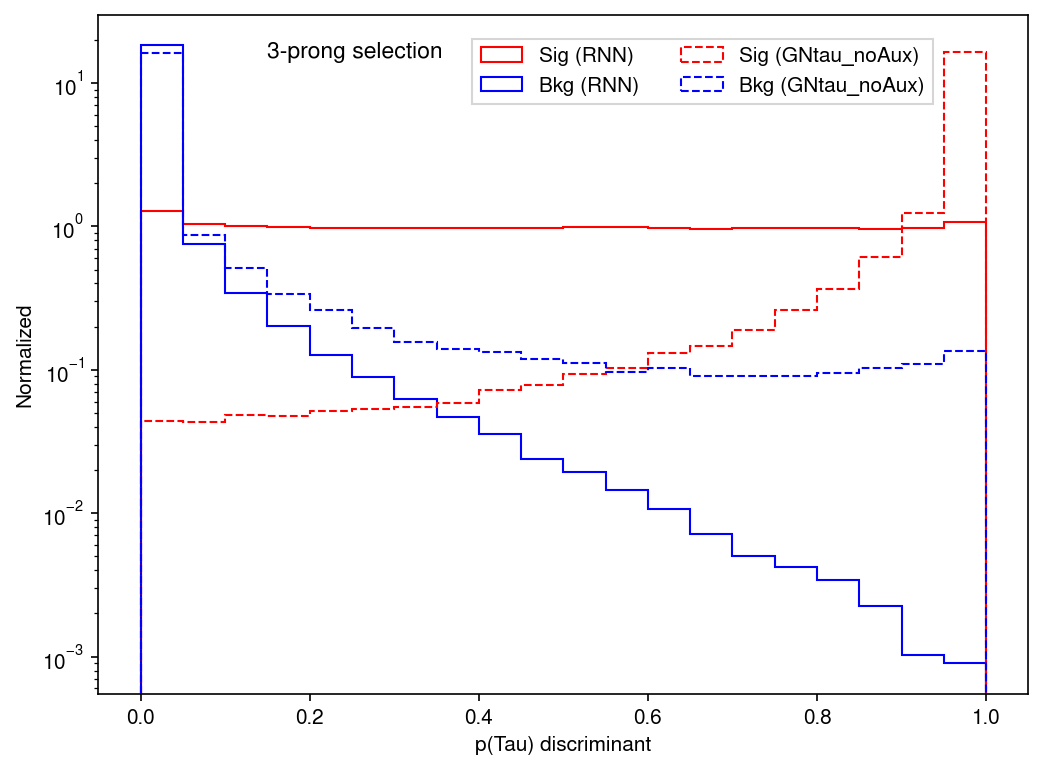

494072


In [24]:
prong_choice = 3

fig, ax = plt.subplots(1, 1, figsize=(8, 6), dpi=150)
ax.hist(results['RNN']['disc'][is_tau & mask & (prongs==prong_choice)], histtype='step', density=True,         range=(0,1), bins=20, color='red', label='Sig (RNN)')
ax.hist(results['RNN']['disc'][is_bkg & mask & (prongs==prong_choice)], histtype='step', density=True,         range=(0,1), bins=20, color='blue', label='Bkg (RNN)')
ax.hist(results['GNtau_noRNN_noAux']['disc'][is_tau & mask & (prongs==prong_choice)], histtype='step', density=True, range=(0,1), bins=20, color='red', linestyle=('dashed'), label='Sig (GNtau_noAux)')
ax.hist(results['GNtau_noRNN_noAux']['disc'][is_bkg & mask & (prongs==prong_choice)], histtype='step', density=True, range=(0,1), bins=20, color='blue', linestyle=('dashed'), label='Bkg (GNtau_noAux)')
ax.text(0.15, 15.0, f'{prong_choice}-prong selection', fontsize=11)
ax.set_xlabel('p(Tau) discriminant')
ax.set_ylabel('Normalized')
ax.legend(loc='upper center', bbox_to_anchor=(0.65, 0.98), ncol=2, fancybox=False, shadow=False)
plt.yscale('log')
plt.savefig(f'discriminants_{prong_choice}p.png', transparent=False)
plt.show()
print( len( results['RNN']['disc'][is_tau & mask & (prongs==prong_choice)] ))

In [55]:
### Get rejection values at the working points

for WP, eff in WP_1p.items():
    print(f'1-prong {WP} ({eff*100}% sig. eff.) ')
    ### get closest value to the working point
    idx = (np.abs(sig_eff - WP_1p[WP])).argmin()
    rej_1p_RNN = (results['RNN']['rej_1'][idx] + results['RNN']['rej_1'][idx+1] + results['RNN']['rej_1'][idx-1])/3
    rej_1p_GNN = (results['GNtau_noRNN']['rej_1'][idx] + results['GNtau_noRNN']['rej_1'][idx+1] + results['GNtau_noRNN']['rej_1'][idx-1])/3
    print('RNN', rej_1p_RNN)
    print('GNN', rej_1p_GNN)
    print('GNN/RNN', rej_1p_GNN/rej_1p_RNN)

for WP, eff in WP_3p.items():
    print(f'3-prong {WP} ({eff*100}% sig. eff.) ')
    ### get closest value to the working point
    idx = (np.abs(sig_eff - WP_3p[WP])).argmin()
    rej_3p_RNN = (results['RNN']['rej_3'][idx] + results['RNN']['rej_3'][idx+1] + results['RNN']['rej_3'][idx-1])/3
    rej_3p_GNN = (results['GNtau_noRNN']['rej_3'][idx] + results['GNtau_noRNN']['rej_3'][idx+1] + results['GNtau_noRNN']['rej_3'][idx-1])/3
    print('RNN', rej_3p_RNN)
    print('GNN', rej_3p_GNN)
    print('GNN/RNN', rej_3p_GNN/rej_3p_RNN)

1-prong Tight (60.0% sig. eff.) 
RNN 30.02998512277017
GNN 669.3882193104678
GNN/RNN 22.29066103675508
1-prong Medium (75.0% sig. eff.) 
RNN 15.454065673643319
GNN 212.40130738535242
GNN/RNN 13.744040686173589
1-prong Loose (85.0% sig. eff.) 
RNN 9.444806141044813
GNN 96.17145378906508
GNN/RNN 10.182469851988545
3-prong Tight (45.0% sig. eff.) 
RNN 407.6366239246856
GNN 7961.927869278599
GNN/RNN 19.53192476333931
3-prong Medium (60.0% sig. eff.) 
RNN 159.41375620101823
GNN 2890.456278406113
GNN/RNN 18.13178703826095
3-prong Loose (75.0% sig. eff.) 
RNN 59.54901576741923
GNN 811.018829367454
GNN/RNN 13.61934901720379


In [56]:
from puma import IntegratedEfficiency, IntegratedEfficiencyPlot

In [57]:
# here the plotting of the Integrated Efficiency curves starts
plot = IntegratedEfficiencyPlot(
    ylabel="Integrated efficiency",
    xlabel="Discriminant",
    #atlas_second_tag="$\\sqrt{s}=13$ TeV, dummy jets \ndummy sample, $f_{c}=0.018$",
    figsize=(6.5, 6),
    y_scale=1.4,
)
for key, val in networks.items():

    plot.add(
        IntegratedEfficiency(
            results[key]['disc'][is_tau & mask & (prongs==3)], 
            results[key]['disc'][is_tau & mask & (prongs==3)],
            tagger=key
        )
    )

/home/fiaccoda/.local/lib/python3.8/site-packages/puma/integrated_eff.py:215: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fcedce17940> has a label of '_child0' which cannot be automatically added to the legend.
  self.axis_top.legend(
/home/fiaccoda/.local/lib/python3.8/site-packages/puma/integrated_eff.py:215: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fcedd25bfd0> has a label of '_child1' which cannot be automatically added to the legend.
  self.axis_top.legend(


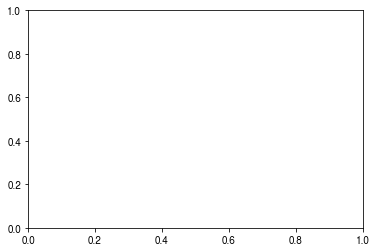

In [58]:
plot.draw()
plot.savefig("integrated_efficiency.png", transparent=False)

# Efficiency/rejection vs. pT

In [59]:
import numpy as np

from puma import VarVsEff, VarVsEffPlot
from puma.utils import get_dummy_2_taggers, logger

In [60]:
rej_pt_bins = np.logspace(np.log10(jet_pt_min),np.log10(2000),8)
#rej_pt_bins = np.concatenate((np.logspace(np.log10(jet_pt_min),np.log10(100),10)[:-1], np.logspace(np.log10(100),np.log10(2000),4)))
effi_unique_bin = np.array([0, 2000])
rej_unique_bin = np.array([0, 2000])

In [78]:
WP_name = 'Loose'
prongness = {'1 prongs':[(prongs==1) ,sig_mask_1, WP_1p, 1],\
             '3 prongs' : [(prongs==3), sig_mask_3, WP_3p, 3]}

p_num = (prongs==1)
sigi = sig_mask_1
eff = WP_1p
prong = 1

plot_sig_eff = VarVsEffPlot(
    mode="sig_eff",
    ylabel="$Tau$-jets efficiency",
    xlabel=r"$p_{T}$ [GeV]",
    logy=False,
    atlas_second_tag="$\\sqrt{s}=13$ TeV, " + "{}-prong".format(prong) ,
    n_ratio_panels=1,
    ymin=0,
    ymax=1.6
)
for network in results.keys():
    lab = network
    if '_' in lab and 'Aux' not in lab:
        lab = lab.split('_')[0]

    vveff_eff = VarVsEff(
        x_var_sig=jet_pt[is_tau & mask & p_num & sigi],
        disc_sig=results[network]['disc'][is_tau & mask & p_num & sigi],
        x_var_bkg=jet_pt[is_bkg & mask & p_num],
        disc_bkg=results[network]['disc'][is_bkg & mask & p_num],
        #bins=np.linspace(20,1000,49),
        #bins= effi_unique_bin, #rej_pt_bins,
        bins=sig_eff,
        #working_point=eff[WP_name],
        disc_cut=disc_cut_1p_RNN[WP_name] if network=="RNN" else disc_cut_1p_GNN[WP_name],
        #fixed_eff_bin=True,
        label=lab,
        )

p_num =  [False False False ... False False False]
[False False False ... False False False]
{'Tight': 0.6, 'Medium': 0.75, 'Loose': 0.85}
p_num =  [False False False ...  True False False]
[False False False ...  True False False]
{'Tight': 0.45, 'Medium': 0.6, 'Loose': 0.75}


In [77]:
for WP_name in ['Tight', 'Medium', 'Loose']:

    for p_num, sigi, eff, prong in prongness.values():
        print("p_num = ", p_num)
        if not apply_true_prongness:
            sigi = np.ones_like(sigi).astype(bool)

        plot_sig_eff = VarVsEffPlot(
            mode="sig_eff",
            ylabel="$Tau$-jets efficiency",
            xlabel=r"$p_{T}$ [GeV]",
            logy=False,
            atlas_second_tag="$\\sqrt{s}=13$ TeV, " + "{}-prong".format(prong) ,
            n_ratio_panels=1,
            ymin=0,
            ymax=1.6
        )

        plot_bkg_rej = VarVsEffPlot(
            mode="bkg_rej",
            ylabel="BKG-jets rejection",
            xlabel=r"$p_{T}$ [GeV]",
            logy=True,
            logx=True,
            atlas_second_tag="$\\sqrt{s}=13$ TeV, " + "{}-prong".format(prong) ,
            n_ratio_panels=1,
            ymin=1,
            xmin=20,
            xmax=2100,
            #ymax= 970 if prong == 1 else 9700,
        )

        for network in results.keys(): 

            # if network not in ['RNN','GNtau_noRNN']:
            #     continue

            lab = network
            if '_' in lab and 'Aux' not in lab:
                lab = lab.split('_')[0]

            vveff_eff = VarVsEff(
                x_var_sig=jet_pt[is_tau & mask & p_num & sigi],
                disc_sig=results[network]['disc'][is_tau & mask & p_num & sigi],
                x_var_bkg=jet_pt[is_bkg & mask & p_num],
                disc_bkg=results[network]['disc'][is_bkg & mask & p_num],
                #bins=np.linspace(20,1000,49),
                #bins= effi_unique_bin, #rej_pt_bins,
                bins=sig_eff,
                #working_point=eff[WP_name],
                disc_cut=disc_cut_1p_RNN[WP_name] if network=="RNN" else disc_cut_1p_GNN[WP_name],
                #fixed_eff_bin=True,
                label=lab,
                )

            vveff_rej = VarVsEff(
                x_var_sig=jet_pt[is_tau & mask & p_num & sigi],
                disc_sig=results[network]['disc'][is_tau & mask & p_num & sigi],
                x_var_bkg=jet_pt[is_bkg & mask & p_num],
                disc_bkg=results[network]['disc'][is_bkg & mask & p_num],
                bins= rej_unique_bin, #rej_pt_bins,
                working_point=eff[WP_name],
                disc_cut=None,
                #fixed_eff_bin=True,
                label=lab,
                )            

            logger.info("Plotting bkg rejection for inclusive efficiency as a function of pt.")
            #print( vveff_rej )
            plot_sig_eff.add(vveff_eff, reference=(network == 'RNN'))
            plot_bkg_rej.add(vveff_rej, reference=(network == 'RNN'))

        plot_sig_eff.atlas_second_tag += "\n{} $(\\epsilon_{}\\tau{}={} \% )$".format(WP_name, '{','}' , eff[WP_name]*100)
        plot_bkg_rej.atlas_second_tag += "\n{} $(\\epsilon_{}\\tau{}={} \% )$".format(WP_name, '{','}' , eff[WP_name]*100)

        # If you want to inverse the discriminant cut you can enable it via
        # plot_sig_eff.set_inverse_cut()
        plot_sig_eff.draw()
        # Drawing a hline indicating inclusive efficiency
        plot_sig_eff.draw_hline(eff[WP_name])
        plot_sig_eff.savefig('p_only'+str(prong)+"_tau_eff_" + WP_name + "_" + network + ".png", transparent=False)
        plot_sig_eff.savefig('p_only'+str(prong)+"_tau_eff_" + WP_name + "_" + network + ".pdf", transparent=False)

        plot_bkg_rej.draw()
        plot_bkg_rej.savefig('p_only'+str(prong)+"_bkg_rej_" + WP_name + "_" + network + ".png", transparent=False)
        plot_bkg_rej.savefig('p_only'+str(prong)+"_bkg_rej_" + WP_name + "_" + network + ".pdf", transparent=False)        

p_num =  [False False False ... False False False]


INFO:puma: Plotting bkg rejection for inclusive efficiency as a function of pt.
INFO:puma: Plotting bkg rejection for inclusive efficiency as a function of pt.
INFO:puma: Plotting bkg rejection for inclusive efficiency as a function of pt.


ZeroDivisionError: division by zero

PRONG = 1
Network =  RNN
Rejection on Background:
Rejection: [  5.92354528  13.87470035  20.57579413  24.39961014  29.6770428
  32.07621951  37.73245614  45.99393939  51.725       51.01010101
  57.68571429  53.66153846  51.71186441  61.7804878   55.4047619
  66.12903226  76.14814815  87.73913043  92.96        74.93939394
  82.07407407  82.875       54.57575758  84.36842105  60.875
  93.         111.72727273  79.14285714  92.18181818 108.875
  62.21428571 160.4        142.8         63.18181818  98.85714286
 144.2         92.625      114.85714286 111.25        85.
 149.16666667 100.125       94.125       97.42857143  82.
  49.83333333  91.33333333  76.        ]
Mean Rej:  76.17168699020648

Efficiency on Signal:
Efficiency: [0.86773643 0.85104014 0.8530398  0.85215653 0.85403488 0.85340659
 0.85597841 0.85453275 0.85385848 0.85055789 0.85414888 0.85749549
 0.85961073 0.8563965  0.86059814 0.85787089 0.85983658 0.86383876
 0.86421353 0.8692221  0.86360929 0.86767114 0.86721424 0.86136206


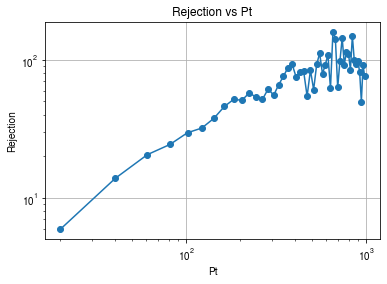

Network =  GNtau_noRNN
Rejection on Background:
Rejection: [113.46984758  88.00292398  63.33168317  60.17788462  59.12403101
  55.66666667  60.58450704  68.99090909  60.26213592  63.92405063
  66.19672131  63.41818182  61.02        63.325       75.06451613
  73.21428571  79.07692308  69.5862069   68.35294118  63.41025641
  58.31578947  62.15625     42.88095238  94.29411765  52.17857143
  54.25        72.29411765  44.32        48.28571429  62.21428571
  43.55       114.57142857  59.5         77.22222222  76.88888889
  72.1         52.92857143  67.          55.625       56.66666667
  89.5         57.21428571  44.29411765  68.2         65.6
  59.8         36.53333333  53.2       ]
Mean Rej:  64.95383302681813

Efficiency on Signal:
Efficiency: [0.75335802 0.86945896 0.90670561 0.92269257 0.93449247 0.94110674
 0.95146721 0.95294464 0.95938943 0.96286812 0.9645269  0.96715086
 0.9698261  0.9720418  0.97319824 0.97753869 0.97611565 0.97656433
 0.97564136 0.98308906 0.97796307 0.98198493 0.9

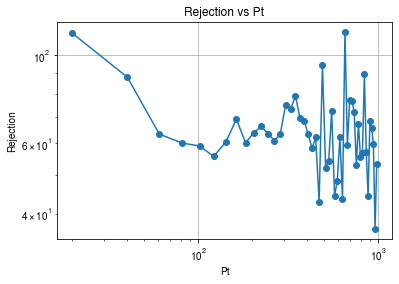

Network =  GNtau_noRNN_noAux
Rejection on Background:
Rejection: [100.27877013  82.59330406  59.92037471  59.6047619   52.96527778
  53.67857143  56.97350993  63.77310924  50.05645161  57.38636364
  59.38235294  55.36507937  62.26530612  60.30952381  56.75609756
  66.12903226  68.53333333  74.74074074  51.64444444  60.31707317
  58.31578947  51.          43.92682927  55.27586207  40.58333333
  52.08        72.29411765  58.31578947  40.56        67.
  45.84210526  61.69230769  79.33333333  49.64285714  62.90909091
  55.46153846  61.75        89.33333333  49.44444444  65.38461538
  63.92857143  53.4         44.29411765  52.46153846  43.73333333
  31.47368421  49.81818182  40.92307692]
Mean Rej:  58.1844026924345

Efficiency on Signal:
Efficiency: [0.7205261  0.83699028 0.87535537 0.89049846 0.90348119 0.91105801
 0.92404725 0.92688038 0.93159333 0.93719895 0.9423271  0.94455521
 0.94667742 0.94789607 0.95244321 0.9584749  0.95642154 0.95945629
 0.95853848 0.96730552 0.96039309 0.9656076 

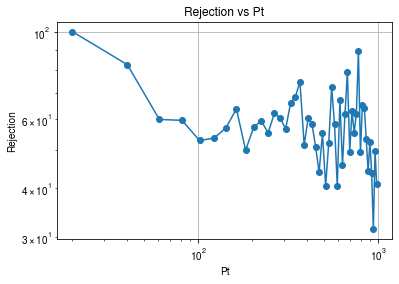

PRONG = 3
Network =  RNN
Rejection on Background:
Rejection: [ 13.9734303   37.81845521  67.          89.31762918 100.4747191
 113.15277778 116.95031056 142.56363636 144.30232558 139.36111111
 143.85964912 150.06521739 215.42857143 135.10526316 183.6
 147.28571429 154.96       267.2        168.65384615 206.28571429
 201.52380952 292.92307692 157.45454545 339.         175.25
 276.33333333 332.57142857 256.875      631.33333333 230.
 238.42857143 132.25       207.42857143 159.77777778 139.8
 178.75       323.6        158.5        250.71428571 112.25
 154.90909091 160.         141.         202.57142857 192.
 175.57142857 167.14285714 120.33333333]
Mean Rej:  184.2843800630886

Efficiency on Signal:
Efficiency: [0.87677678 0.86496117 0.86058891 0.86056681 0.86249233 0.85737555
 0.85643473 0.85012097 0.85499651 0.85515511 0.85049088 0.86067335
 0.85816555 0.85632513 0.87764867 0.87769784 0.86354582 0.88029021
 0.87335092 0.87482014 0.87478849 0.88828829 0.88565891 0.85376344
 0.87857143 0.8

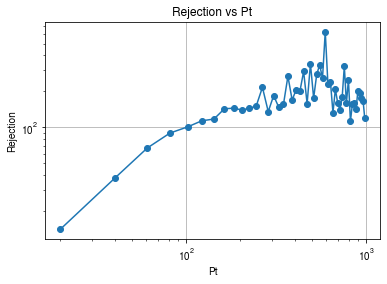

Network =  GNtau_noRNN
Rejection on Background:
Rejection: [ 547.76647564  447.44756554  387.32155477  455.58914729  361.3030303
  479.23529412  376.58        412.68421053  344.72222222  334.46666667
  221.62162162  313.77272727  464.          285.22222222  417.27272727
  242.58823529  430.44444444  572.57142857  487.22222222  481.33333333
  384.72727273  476.          288.66666667  762.75        254.90909091
  310.875       776.          342.5        1894.          460.
 1669.          529.          726.          239.66666667  199.71428571
  286.         1618.          317.         1755.          299.33333333
  284.          200.          310.2         354.5         448.
 1229.          585.          361.        ]
Mean Rej:  529.6668217781865

Efficiency on Signal:
Efficiency: [0.70946501 0.82198447 0.86428767 0.89211779 0.91006753 0.92051082
 0.92270975 0.93098179 0.93273934 0.93932482 0.93884993 0.94126074
 0.94944072 0.9479107  0.94600137 0.93685052 0.94721116 0.94921403
 0.9472295

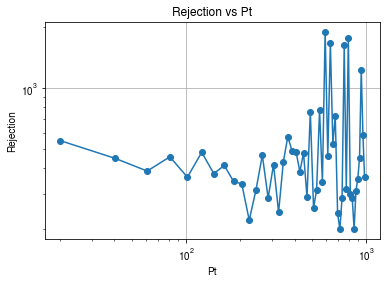

Network =  GNtau_noRNN_noAux
Rejection on Background:
Rejection: [ 551.71861472  434.43090909  379.28027682  405.31724138  340.65714286
  344.23943662  336.23214286  320.04081633  354.57142857  304.06060606
  241.17647059  276.12        464.          342.26666667  353.07692308
  515.5         387.4         286.28571429  398.63636364  433.2
  384.72727273  544.          266.46153846  305.1         280.4
  355.28571429  388.          256.875       473.5         920.
 1669.          529.          726.          287.6         279.6
  476.66666667  809.          317.          585.          179.6
  568.          400.          517.          283.6         672.
  614.5        1170.          361.        ]
Mean Rej:  460.14847803527306

Efficiency on Signal:
Efficiency: [0.54056949 0.68959448 0.74647412 0.7814126  0.81233009 0.82799062
 0.84486874 0.85126703 0.85831586 0.86701642 0.87180926 0.875
 0.88948546 0.88036634 0.89405332 0.88169464 0.87848606 0.8923821
 0.87730871 0.88633094 0.91201354 0.

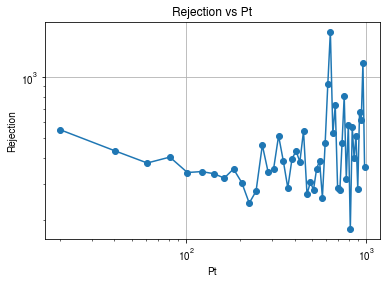

 Used bins =  [  20.           40.41666667   60.83333333   81.25        101.66666667
  122.08333333  142.5         162.91666667  183.33333333  203.75
  224.16666667  244.58333333  265.          285.41666667  305.83333333
  326.25        346.66666667  367.08333333  387.5         407.91666667
  428.33333333  448.75        469.16666667  489.58333333  510.
  530.41666667  550.83333333  571.25        591.66666667  612.08333333
  632.5         652.91666667  673.33333333  693.75        714.16666667
  734.58333333  755.          775.41666667  795.83333333  816.25
  836.66666667  857.08333333  877.5         897.91666667  918.33333333
  938.75        959.16666667  979.58333333 1000.        ]
 Used WP =  0.75  at GNN cut =  0.9985194802284241


In [62]:
def plot_rejection_vs_pt(x_var_sig, disc_sig, x_var_bkg, disc_bkg, bins, working_point, disc_cut_value):
    
    #flat_dict[s] = Flattener(pt_binning, mu_bins_extended, self.eff)
    passed_bkg = disc_bkg > disc_cut_value
    passed_sig = disc_sig > disc_cut_value
    
    # Compute histogram of passed background values
    hist_pssd_bkg, edges_pssd_bkg = np.histogram(x_var_bkg[passed_bkg], bins=np.linspace(20, 1000, 49))
    # Compute histogram of passed signal values
    hist_pssd_sig, edges_pssd_sig = np.histogram(x_var_sig[passed_sig], bins=np.linspace(20, 1000, 49))

    # Compute histogram of all background values
    hist_bkg, edges_bkg = np.histogram(x_var_bkg, bins=np.linspace(20, 1000, 49))
    # Compute histogram of all signal values
    hist_sig, edges_sig = np.histogram(x_var_sig, bins=np.linspace(20, 1000, 49))
    
    # Calculate rejection on background
    rejection_bkg = 1 / (hist_pssd_bkg / hist_bkg)

    # Calculate efficiency on signal
    efficiency_sig = hist_pssd_sig / hist_sig

    # Calculate mean rejection value
    mean_rejection = np.mean(rejection_bkg)
    # Print the results
    print("Rejection on Background:")
    #print("Bins:", edges_pssd_bkg)
    print("Rejection:", rejection_bkg)
    print("Mean Rej: ", mean_rejection)

    print("\nEfficiency on Signal:")
    #print("Bins:", edges_pssd_sig)
    print("Efficiency:", efficiency_sig)
    """
    # Calculate signal and background efficiencies
    signal_eff = np.sum(disc_sig > disc_cut_value) / len(disc_sig)
    background_eff = np.sum(disc_bkg > disc_cut_value) / len(disc_bkg)

    # Calculate signal and background rejections
    signal_rejection = 1 / signal_eff
    background_rejection = 1 / background_eff

    # Create histograms for signal and background
    hist_sig, edges_sig = np.histogram(x_var_sig, bins=bins)
    hist_bkg, edges_bkg = np.histogram(x_var_bkg, bins=bins)

    # Calculate rejection values per bin
    rejection_values = background_rejection * (hist_bkg / len(x_var_bkg)) / (signal_rejection * (hist_sig / len(x_var_sig)))
    """

    # Plot rejection vs pt
    plt.plot(edges_bkg[:-1], rejection_bkg, marker='o', linestyle='-')
    plt.xlabel('Pt')
    plt.xscale('log')
    plt.ylabel('Rejection')
    plt.yscale('log')
    plt.title('Rejection vs Pt')
    plt.grid(True)
    plt.show()

    return rejection_bkg, mean_rejection

# Example usage:
rej_givenWP = {}
WP_NAME = "Loose"
for p_num, sigi, eff, prong in prongness.values():
    print("PRONG =", prong)
    for network in results.keys():
        print('Network = ',network)
        rej_givenWP[network], _ = plot_rejection_vs_pt(
                    x_var_sig=jet_pt[is_tau & mask & p_num & sigi],
                    disc_sig=results[network]['disc'][is_tau & mask & p_num & sigi],
                    x_var_bkg=jet_pt[is_bkg & mask & p_num],
                    disc_bkg=results[network]['disc'][is_bkg & mask & p_num],
                    #bins=np.linspace(20,1000,49),
                    bins=rej_pt_bins,
                    working_point=eff[WP_NAME],
                    disc_cut_value = disc_cut_1p_RNN[WP_NAME] if network == "RNN" else disc_cut_1p_GNN[WP_NAME],
        )
print(" Used bins = ", np.linspace(20,1000,49))
print(" Used WP = ", eff[WP_name]," at GNN cut = ", disc_cut_1p_GNN["Tight"])

### Def or RejPlot by taucp

In [46]:
from utils_DF_plot_tau_ziv import Plot

ModuleNotFoundError: No module named 'utils_DF_plot_tau_ziv'

In [58]:
class Flattener_1D:
    """Efficiency flattener.
    """
    def __init__(self, x_bins, eff):
        self.x_bins = x_bins
        self.eff = eff
        self.cutmap = None

    def fit(self, x, values):
        """
        Fits the flattener.

        Returns:
        --------
        passes_thr : (N,) array of bools
            Array indicating which of the inputs pass the working point.
        """
        x_binned = np.digitize(x, bins=self.x_bins)
        print("x_binned = ", x_binned)
        x_idx = x_binned - 1
        print("x_idx = ",x_idx)
        
        x_idx = x_binned - 1

        # Check if any element in x_idx is equal to len(self.x_bins) - 1
        if np.any(x_idx == len(self.x_bins) - 1):
            # Subtract 1 from each element where the condition is true
            x_idx[x_idx == len(self.x_bins) - 1] -= 1

        print("x_idx = ", x_idx)

        # Flatten x_binned to make it a 1D array
        x_binned_flat = np.concatenate(x_binned)

        # Ensure x_binned_flat is a 1D integer array
        x_binned_flat = x_binned_flat.astype(int)

        cut_values = [np.percentile(values[x_binned_flat == bin_idx], 100 * (1 - self.eff)) for bin_idx in range(1, len(self.x_bins))]
        print("cut_values = ", cut_values)
        
        #cut_values = [np.percentile(values[x_binned == bin_idx], 100 * (1 - self.eff)) for bin_idx in range(1, len(self.x_bins))]
        #print("cut_values = ", cut_values)
        
        self.cutmap = np.array(cut_values)
        return values > self.cutmap[x_idx]

    def passes_thr(self, x, values):
        """
        Checks which entries pass the working point.

        Returns:
        --------
        passes_thr : (N,) array of bools
            Array indicating which of the inputs pass the working point.
        """
        if self.cutmap is None:
            return None

        x_binned = np.digitize(x, bins=self.x_bins)
        x_idx = x_binned - 1
        # Check if any element in x_idx is equal to len(self.x_bins) - 1
        if np.any(x_idx == len(self.x_bins) - 1):
            # Subtract 1 from each element where the condition is true
            x_idx[x_idx == len(self.x_bins) - 1] -= 1

        passes_thr = values > self.cutmap[x_idx]

        return passes_thr

# Example usage:
rej_givenWP = {}
WP_NAME = "Loose"
for p_num, sigi, eff, prong in prongness.values():
    print("PRONG =", prong)
    for network in results.keys():
        print('Network = ',network)
        x_var_sig=jet_pt[is_tau & mask & p_num & sigi],
        disc_sig=results[network]['disc'][is_tau & mask & p_num & sigi],
        x_var_bkg=jet_pt[is_bkg & mask & p_num],
        disc_bkg=results[network]['disc'][is_bkg & mask & p_num],
        x_bins=np.linspace(20,1000,49)
        
        flattener = Flattener_1D(x_bins,  eff[WP_NAME])
        flattener.fit(x_var_sig,  disc_sig)
        passes_thr = flattener.passes_thr(x_var_bkg,  disc_bkg)
        
print(" Used bins = ", np.linspace(20,1000,49))
print(" Used WP = ", eff[WP_name]," at GNN cut = ", disc_cut_1p_GNN["Tight"])

PRONG = 1
Network =  RNN
x_binned =  [[ 1 49  1 ... 49  1 17]]
x_idx =  [[ 0 48  0 ... 48  0 16]]
x_idx =  [[ 0 47  0 ... 47  0 16]]


TypeError: only integer scalar arrays can be converted to a scalar index

In [42]:
np.divide( rej_givenWP['GNtau_noRNN'], rej_givenWP['RNN'] )

array([24.43807362, 24.43807362, 24.43807362, 24.43807362, 24.43807362,
       24.43807362, 24.43807362, 24.43807362, 24.43807362, 24.43807362,
       24.43807362, 24.43807362, 24.43807362, 24.43807362, 24.43807362,
       24.43807362, 24.43807362, 24.43807362, 24.43807362, 24.43807362,
       24.43807362, 24.43807362, 24.43807362, 24.43807362, 24.43807362,
       24.43807362, 24.43807362, 24.43807362, 24.43807362, 24.43807362,
       24.43807362, 24.43807362, 24.43807362, 24.43807362, 24.43807362,
       24.43807362, 24.43807362, 24.43807362, 24.43807362, 24.43807362,
       24.43807362, 24.43807362, 24.43807362, 24.43807362, 24.43807362,
       24.43807362, 24.43807362, 24.43807362])

In [43]:
print(  rej_givenWP['RNN'] )

[ 92.29744604  75.7304744   64.75258911  59.75053326  57.61404738
  58.49757828  63.49076958  73.35615489  79.64212938  84.07642909
  84.49383552  90.82244019  99.14127782 107.95273908 115.24950432
 121.09662899 141.74136485 178.0298845  212.50595215 228.96776775
 263.04429368 252.04301341 246.60330258 241.02381789 245.24458429
 247.5826037  233.01700639 211.45322678 210.19514839 222.33864068
 189.22653341 208.20425567 196.09585739 211.29517707 181.46440233
 203.60434336 223.44342896 244.6374923  285.25902168 301.25407086
 288.45665521 332.06065717 268.74886802 251.63821287 275.81440508
 255.06409229 247.00589617 224.76355732]


### RNN-only crosscheck

INFO:puma: Plotting bkg rejection for inclusive efficiency as a function of pt.
INFO:puma: Plotting bkg rejection for inclusive efficiency as a function of pt.
INFO:puma: Plotting bkg rejection for inclusive efficiency as a function of pt.
INFO:puma: Plotting bkg rejection for inclusive efficiency as a function of pt.
INFO:puma: Plotting bkg rejection for inclusive efficiency as a function of pt.
INFO:puma: Plotting bkg rejection for inclusive efficiency as a function of pt.


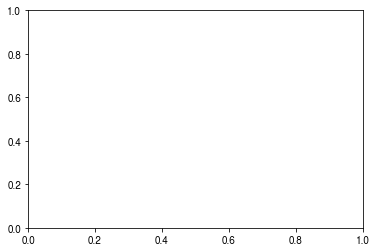

In [72]:
colors = {
    'Loose': 'green',
    'Medium': 'blue',
    'Tight': 'red',
}

for p_num, sigi, eff, prong in prongness.values():

    if not apply_true_prongness:
        sigi = np.ones_like(sigi).astype(bool)

    plot_sig_eff = VarVsEffPlot(
        mode="sig_eff",
        ylabel="$Tau$-jets efficiency",
        xlabel=r"$p_{T}$ [GeV]",
        logy=False,
        atlas_second_tag="$\\sqrt{s}=13$ TeV, " + "{}-prong".format(prong) ,
        n_ratio_panels=0,
        ymin=0,
        ymax=1.6
    )

    plot_bkg_rej = VarVsEffPlot(
        mode="bkg_rej",
        ylabel="BKG-jets rejection",
        xlabel=r"$p_{T}$ [GeV]",
        logy=False,
        logx=True,
        atlas_second_tag="$\\sqrt{s}=13$ TeV, " + "{}-prong".format(prong) ,
        n_ratio_panels=0,
        ymin=0,
        ymax=1000. if prong == 1 else 10000.,
    )

    network = 'RNN'

    for WP_name in ['Tight', 'Medium', 'Loose']:

        vveff_eff = VarVsEff(
            x_var_sig=jet_pt[is_tau & mask & p_num & sigi],
            disc_sig=results[network]['disc'][is_tau & mask & p_num & sigi],
            x_var_bkg=jet_pt[is_bkg & mask & p_num],
            disc_bkg=results[network]['disc'][is_bkg & mask & p_num],
            bins=np.linspace(20,1000,49),
            working_point=eff[WP_name],
            disc_cut=None,
            #fixed_eff_bin=False,
            label='{} {} $(\\epsilon_{}\\tau{}={} \% )$'.format(network,WP_name, '{','}' , eff[WP_name]*100),
            colour=colors[WP_name],
            )
        
        vveff_rej = VarVsEff(
            x_var_sig=jet_pt[is_tau & mask & p_num & sigi],
            disc_sig=results[network]['disc'][is_tau & mask & p_num & sigi],
            x_var_bkg=jet_pt[is_bkg & mask & p_num],
            disc_bkg=results[network]['disc'][is_bkg & mask & p_num],
            bins=np.logspace(np.log10(20),np.log10(2000),11),
            working_point=eff[WP_name],
            disc_cut=None,
            #fixed_eff_bin=False,
            label='{} {} $(\\epsilon_{}\\tau{}={} \% )$'.format(network,WP_name, '{','}' , eff[WP_name]*100),
            colour=colors[WP_name],
            )            

        logger.info("Plotting bkg rejection for inclusive efficiency as a function of pt.")

        plot_sig_eff.add(vveff_eff, reference=False)
        plot_bkg_rej.add(vveff_rej, reference=False)

        # Drawing a hline indicating inclusive efficiency
        plot_sig_eff.draw_hline(eff[WP_name])

    # If you want to inverse the discriminant cut you can enable it via
    # plot_sig_eff.set_inverse_cut()
    plot_sig_eff.draw()
    plot_sig_eff.savefig('p_only'+str(prong)+"_tau_eff_RNNcrosscheck.png", transparent=False)
    plot_sig_eff.savefig('p_only'+str(prong)+"_tau_eff_RNNcrosscheck.pdf", transparent=False)

    plot_bkg_rej.draw()
    plot_bkg_rej.savefig('p_only'+str(prong)+"_bkg_rej_RNNcrosscheck.png", transparent=False)
    plot_bkg_rej.savefig('p_only'+str(prong)+"_bkg_rej_RNNcrosscheck.pdf", transparent=False)    

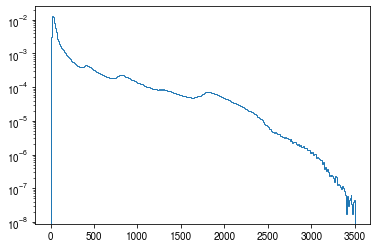

In [73]:
plt.hist(jet_pt, bins=350, density=True, range=(0, 3500), histtype='step')
plt.yscale('log')

(array([8.81957e+05, 7.94460e+04, 2.92300e+04, 2.30560e+04, 1.50430e+04,
        9.50000e+03, 8.65500e+03, 8.84200e+03, 6.10400e+03, 4.24600e+03,
        3.27600e+03, 3.07300e+03, 2.42900e+03, 1.92100e+03, 1.91200e+03,
        2.54200e+03, 2.45900e+03, 1.79900e+03, 1.21100e+03, 8.77000e+02,
        6.47000e+02, 2.84000e+02, 1.48000e+02, 9.00000e+01, 6.10000e+01,
        4.20000e+01, 2.10000e+01, 9.00000e+00, 3.00000e+00, 1.00000e+00]),
 array([  15.000286,  129.73479 ,  244.4693  ,  359.2038  ,  473.9383  ,
         588.6728  ,  703.4073  ,  818.1418  ,  932.87634 , 1047.6108  ,
        1162.3453  , 1277.0798  , 1391.8143  , 1506.5488  , 1621.2833  ,
        1736.0178  , 1850.7523  , 1965.4868  , 2080.2214  , 2194.9558  ,
        2309.6904  , 2424.4248  , 2539.1594  , 2653.8938  , 2768.6284  ,
        2883.3628  , 2998.0974  , 3112.8318  , 3227.5664  , 3342.3008  ,
        3457.0354  ], dtype=float32),
 <BarContainer object of 30 artists>)

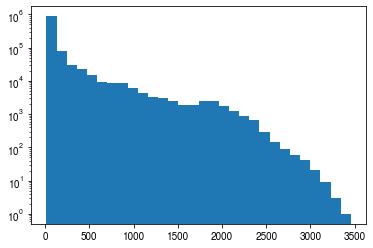

In [74]:
plt.hist(jet_pt[is_bkg & mask & (prongs==3)], bins = 30, log = True)

(array([   911.,    677.,    572.,    539.,    503.,    505.,    507.,
           511.,    501.,    495.,    526.,    615.,    592.,    616.,
           668.,    709.,    804.,    866.,    998.,   1120.,   1205.,
          1493.,   1901.,   2326.,   2939.,   3943.,   5917.,   9858.,
         21246., 430009.]),
 array([1.29114105e-05, 3.33457366e-02, 6.66785613e-02, 1.00011379e-01,
        1.33344203e-01, 1.66677028e-01, 2.00009853e-01, 2.33342677e-01,
        2.66675502e-01, 3.00008327e-01, 3.33341151e-01, 3.66673976e-01,
        4.00006801e-01, 4.33339626e-01, 4.66672450e-01, 5.00005245e-01,
        5.33338070e-01, 5.66670895e-01, 6.00003719e-01, 6.33336544e-01,
        6.66669369e-01, 7.00002193e-01, 7.33335018e-01, 7.66667843e-01,
        8.00000668e-01, 8.33333492e-01, 8.66666317e-01, 8.99999142e-01,
        9.33331966e-01, 9.66664791e-01, 9.99997616e-01], dtype=float32),
 <BarContainer object of 30 artists>)

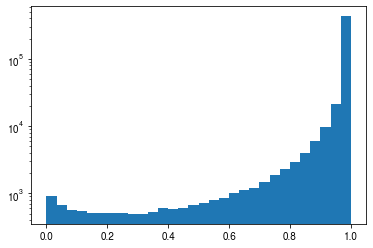

In [75]:
plt.hist(results['GNtau_noRNN']['disc'][is_tau & mask & (prongs==3)], bins = 30, log = True)

In [76]:
for key,value in results.items():
    print(key)

RNN
GNtau_noRNN
